#Import Library

In [ ]:
pip install ccxt cryptocompare pycoingecko websockets ta nest_asyncio tensorflow scikeras catboost optuna

In [ ]:
pip install -U scikit-learn scikeras tensorflow

In [ ]:
#Import libraries
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
from scipy.stats import pearsonr, jarque_bera
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, FunctionTransformer, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, confusion_matrix, f1_score, mean_absolute_percentage_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline as pl
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
import warnings
import requests
import ccxt
from cryptocompare import get_historical_price_minute
from pycoingecko import CoinGeckoAPI
import json
from datetime import datetime, timedelta
import time
import websockets
import asyncio
import nest_asyncio
import aiohttp
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from ta import add_all_ta_features  # Library khusus technical analysis
from typing import Dict, Any
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Attention, Input, Bidirectional
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from datetime import datetime
from collections import deque
from google.colab import files, drive
import joblib
import pickle
import optuna
from optuna.samplers import TPESampler
warnings.filterwarnings("ignore")


import numpy as np
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline as pl
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor


import numpy as np
import pandas as pd
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


%matplotlib inline

# Import Historical Data

In [ ]:
def fetch_historical_data(symbol='BTC', currency='USD', days=365):
    # CryptoCompare (OHLCV per menit)
    cc_url = f"https://min-api.cryptocompare.com/data/v2/histominute?fsym={symbol}&tsym={currency}&limit={min(days*1440, 2000)}"
    cc_data = requests.get(cc_url).json()['Data']['Data']
    df_cc = pd.DataFrame(cc_data)
    df_cc['time'] = pd.to_datetime(df_cc['time'], unit='s', utc=True)

    # CoinGecko (Metadata)
    cg = CoinGeckoAPI()
    cg_data = cg.get_coin_market_chart_by_id(
        id='bitcoin',
        vs_currency=currency.lower(),
        days=days
    )
    df_cg = pd.DataFrame({
        'time': pd.to_datetime([x[0] for x in cg_data['prices']], unit='ms', utc=True),
        'market_cap': [x[1] for x in cg_data['market_caps']],
        'total_volume': [x[1] for x in cg_data['total_volumes']]
    })

    # Gabungkan
    return pd.merge_asof(
        df_cc.sort_values('time'),
        df_cg.sort_values('time'),
        on='time',
        direction='nearest'
    ).set_index('time').resample('1S').ffill()

btc_data = fetch_historical_data(days=30)

In [ ]:
btc_data.head()

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,market_cap,total_volume
time,,,,,,,,,,
2025-08-31 18:04:00+00:00,109009.78,108963.19,109009.7,5.162,562581.42,108964.0,direct,,2.169975e+12,2.430075e+10
2025-08-31 18:04:01+00:00,109009.78,108963.19,109009.7,5.162,562581.42,108964.0,direct,,2.169975e+12,2.430075e+10
2025-08-31 18:04:02+00:00,109009.78,108963.19,109009.7,5.162,562581.42,108964.0,direct,,2.169975e+12,2.430075e+10
2025-08-31 18:04:03+00:00,109009.78,108963.19,109009.7,5.162,562581.42,108964.0,direct,,2.169975e+12,2.430075e+10
2025-08-31 18:04:04+00:00,109009.78,108963.19,109009.7,5.162,562581.42,108964.0,direct,,2.169975e+12,2.430075e+10


In [ ]:
btcdata = btc_data.drop(['conversionType', 'conversionSymbol'], axis=1)

In [ ]:
btcdata

,high,low,open,volumefrom,volumeto,close,market_cap,total_volume
time,,,,,,,,
2025-08-31 18:04:00+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10
2025-08-31 18:04:01+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10
2025-08-31 18:04:02+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10
2025-08-31 18:04:03+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10
2025-08-31 18:04:04+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10
...,...,...,...,...,...,...,...,...
2025-09-02 03:23:56+00:00,110309.28,110278.67,110281.06,10.920,1204272.22,110304.58,2.197806e+12,4.320382e+10
2025-09-02 03:23:57+00:00,110309.28,110278.67,110281.06,10.920,1204272.22,110304.58,2.197806e+12,4.320382e+10
2025-09-02 03:23:58+00:00,110309.28,110278.67,110281.06,10.920,1204272.22,110304.58,2.197806e+12,4.320382e+10


In [ ]:
btcdata.rename(columns={'volumeto': 'volume'}, inplace=True)

In [ ]:
btcdata

,high,low,open,volumefrom,volume,close,market_cap,total_volume
time,,,,,,,,
2025-08-31 18:04:00+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10
2025-08-31 18:04:01+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10
2025-08-31 18:04:02+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10
2025-08-31 18:04:03+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10
2025-08-31 18:04:04+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10
...,...,...,...,...,...,...,...,...
2025-09-02 03:23:56+00:00,110309.28,110278.67,110281.06,10.920,1204272.22,110304.58,2.197806e+12,4.320382e+10
2025-09-02 03:23:57+00:00,110309.28,110278.67,110281.06,10.920,1204272.22,110304.58,2.197806e+12,4.320382e+10
2025-09-02 03:23:58+00:00,110309.28,110278.67,110281.06,10.920,1204272.22,110304.58,2.197806e+12,4.320382e+10


#Feature Engineering

In [ ]:
btcdata['next_price'] = btcdata['close'].shift(-1800)
btcdata = btcdata.dropna(subset=['next_price'])

In [ ]:
btcdata

,high,low,open,volumefrom,volume,close,market_cap,total_volume,next_price
time,,,,,,,,,
2025-08-31 18:04:00+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10,109125.27
2025-08-31 18:04:01+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10,109125.27
2025-08-31 18:04:02+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10,109125.27
2025-08-31 18:04:03+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10,109125.27
2025-08-31 18:04:04+00:00,109009.78,108963.19,109009.70,5.162,562581.42,108964.00,2.169975e+12,2.430075e+10,109125.27
...,...,...,...,...,...,...,...,...,...
2025-09-02 02:53:56+00:00,109835.85,109810.95,109823.39,9.224,1013419.30,109810.95,2.185830e+12,4.113347e+10,110304.58
2025-09-02 02:53:57+00:00,109835.85,109810.95,109823.39,9.224,1013419.30,109810.95,2.185830e+12,4.113347e+10,110304.58
2025-09-02 02:53:58+00:00,109835.85,109810.95,109823.39,9.224,1013419.30,109810.95,2.185830e+12,4.113347e+10,110304.58


In [ ]:
btcdata.columns

Index(['high', 'low', 'open', 'volumefrom', 'volume', 'close', 'market_cap',
       'total_volume', 'next_price'],
      dtype='object')

In [ ]:
btcdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118201 entries, 2025-08-31 18:04:00+00:00 to 2025-09-02 02:54:00+00:00
Freq: s
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   high          118201 non-null  float64
 1   low           118201 non-null  float64
 2   open          118201 non-null  float64
 3   volumefrom    118201 non-null  float64
 4   volume        118201 non-null  float64
 5   close         118201 non-null  float64
 6   market_cap    118201 non-null  float64
 7   total_volume  118201 non-null  float64
 8   next_price    118201 non-null  float64
dtypes: float64(9)
memory usage: 9.0 MB


In [ ]:
btcdata.isnull().sum()

,0
high,0
low,0
open,0
volumefrom,0
volume,0
close,0
market_cap,0
total_volume,0
next_price,0


In [ ]:
btcdata.shape

(118201, 9)

In [ ]:
btcdata.describe()

,high,low,open,volumefrom,volume,close,market_cap,total_volume,next_price
count,118201.000000,118201.000000,118201.000000,118201.000000,1.182010e+05,118201.000000,1.182010e+05,1.182010e+05,118201.000000
mean,108746.814125,108693.229963,108719.759922,14.137728,1.536407e+06,108720.164877,2.164833e+12,3.379647e+10,108738.749854
std,612.281736,617.335629,614.372027,14.055144,1.527580e+06,614.827672,1.201232e+10,6.225129e+09,642.301323
min,107304.380000,107271.390000,107294.750000,0.298400,3.256278e+04,107294.750000,2.137715e+12,2.430075e+10,107294.750000
25%,108269.560000,108200.960000,108241.490000,5.719000,6.239777e+05,108241.490000,2.155732e+12,2.714639e+10,108241.490000
50%,108969.430000,108921.710000,108947.190000,10.880000,1.187328e+06,108947.190000,2.168607e+12,3.527969e+10,108947.190000
75%,109163.750000,109124.700000,109139.800000,17.830000,1.938514e+06,109140.270000,2.173651e+12,3.896780e+10,109153.330000
max,109921.230000,109845.780000,109892.970000,258.310000,2.813886e+07,109892.970000,2.185830e+12,4.297551e+10,110610.470000


In [ ]:
btcdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 118201 entries, 2025-08-31 18:04:00+00:00 to 2025-09-02 02:54:00+00:00
Freq: s
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   high          118201 non-null  float64
 1   low           118201 non-null  float64
 2   open          118201 non-null  float64
 3   volumefrom    118201 non-null  float64
 4   volume        118201 non-null  float64
 5   close         118201 non-null  float64
 6   market_cap    118201 non-null  float64
 7   total_volume  118201 non-null  float64
 8   next_price    118201 non-null  float64
dtypes: float64(9)
memory usage: 9.0 MB


#Check Correlation

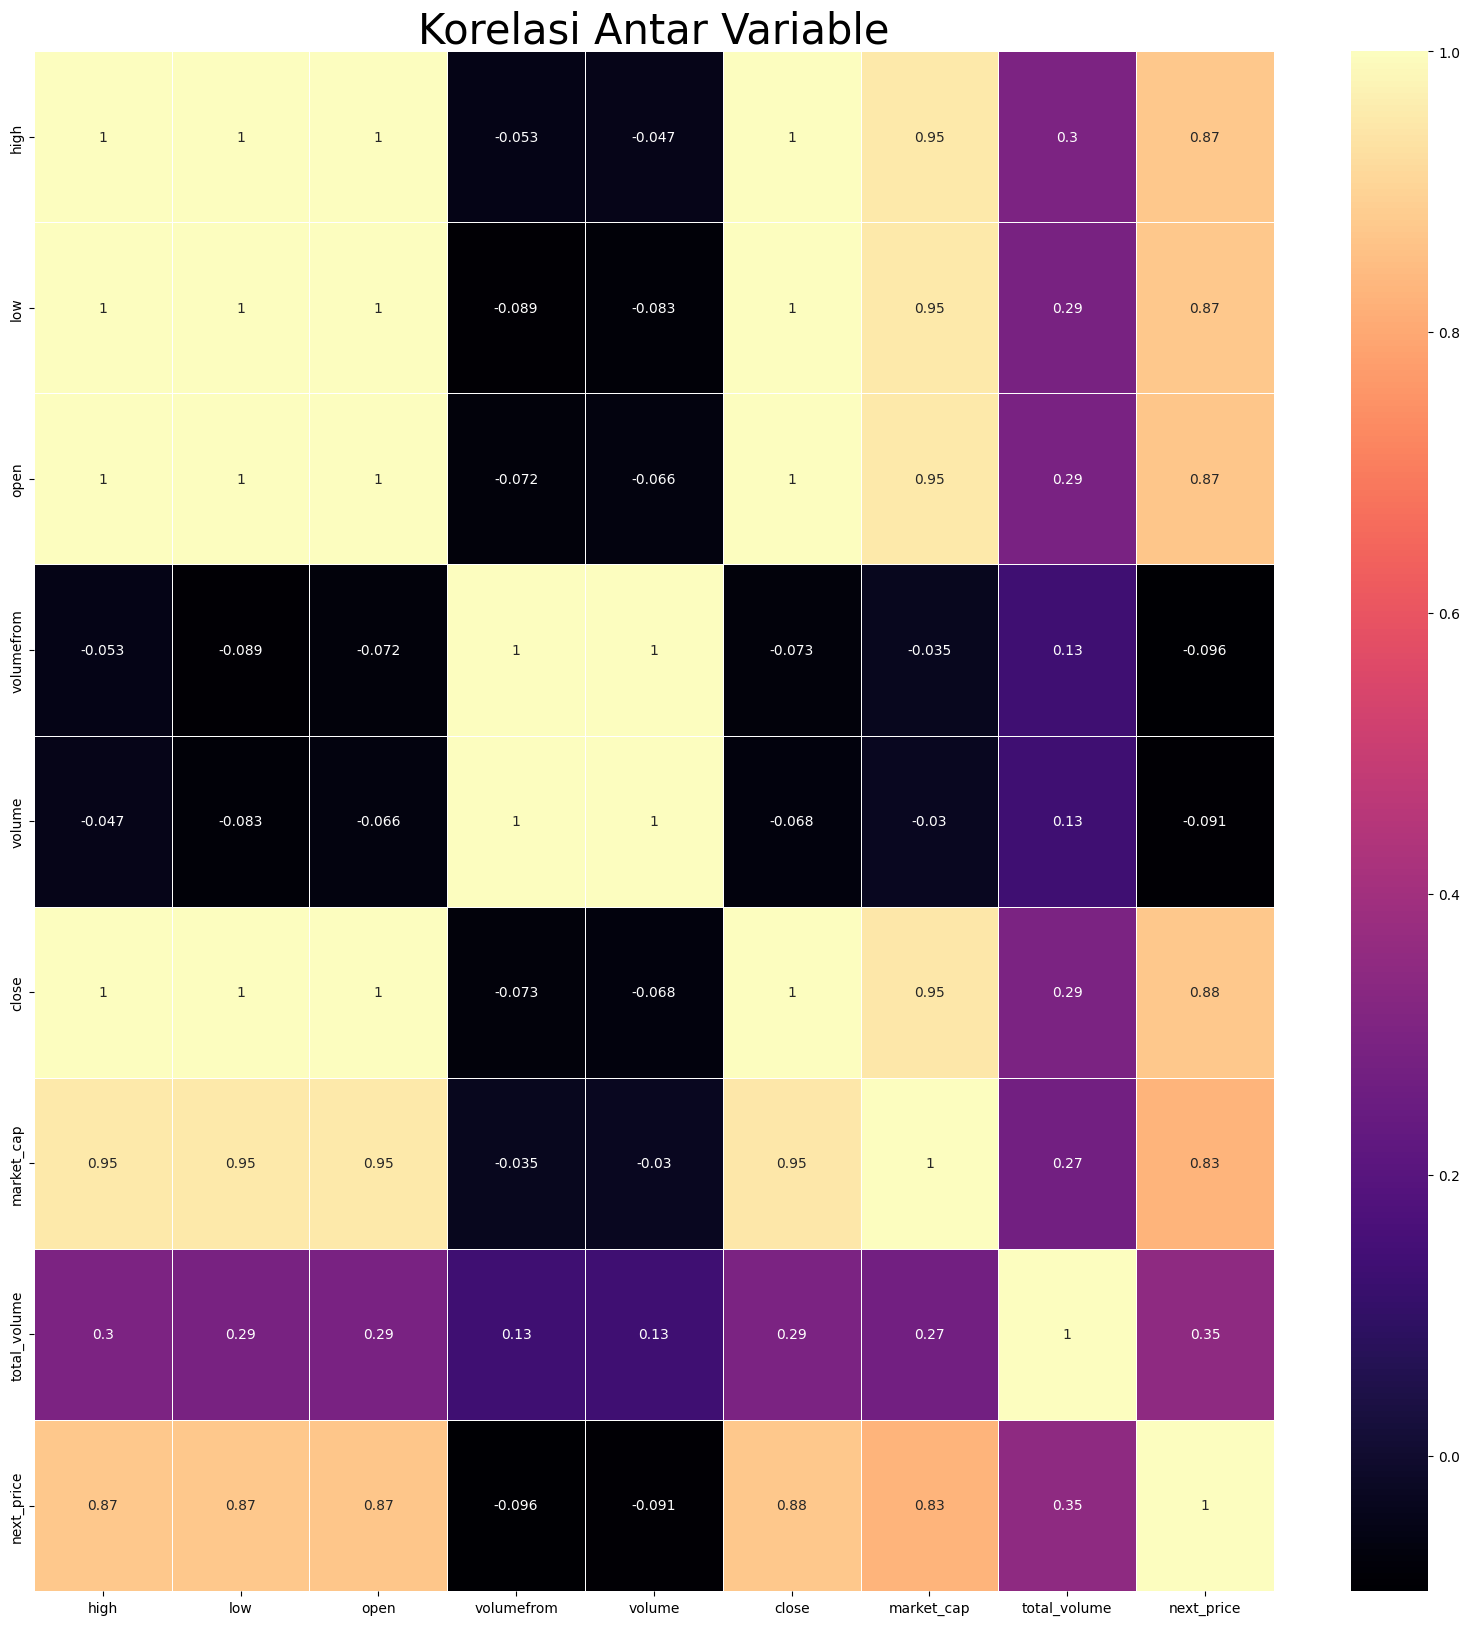

In [ ]:
# melihat korelasi antar variable untuk mencari feature yang penting
plt.figure(figsize=(20,20))
cor = btcdata.corr()
sns.heatmap(cor,annot=True, linewidth=.5, cmap="magma")
plt.title('Korelasi Antar Variable', fontsize = 30)
plt.show()

In [ ]:
cor_matrix = btcdata.corr()
cor_matrix['next_price'].sort_values()

,next_price
volumefrom,-0.096385
volume,-0.091202
total_volume,0.348818
market_cap,0.825354
open,0.870874
high,0.873500
low,0.873533
close,0.875730
next_price,1.000000


In [ ]:
select_columns = ['open', 'high', 'low', 'close', 'market_cap', 'next_price']
btcdata = btcdata[select_columns]

In [ ]:
btcdata

,open,high,low,close,market_cap,next_price
time,,,,,,
2025-08-31 18:04:00+00:00,109009.70,109009.78,108963.19,108964.00,2.169975e+12,109125.27
2025-08-31 18:04:01+00:00,109009.70,109009.78,108963.19,108964.00,2.169975e+12,109125.27
2025-08-31 18:04:02+00:00,109009.70,109009.78,108963.19,108964.00,2.169975e+12,109125.27
2025-08-31 18:04:03+00:00,109009.70,109009.78,108963.19,108964.00,2.169975e+12,109125.27
2025-08-31 18:04:04+00:00,109009.70,109009.78,108963.19,108964.00,2.169975e+12,109125.27
...,...,...,...,...,...,...
2025-09-02 02:53:56+00:00,109823.39,109835.85,109810.95,109810.95,2.185830e+12,110304.58
2025-09-02 02:53:57+00:00,109823.39,109835.85,109810.95,109810.95,2.185830e+12,110304.58
2025-09-02 02:53:58+00:00,109823.39,109835.85,109810.95,109810.95,2.185830e+12,110304.58


#Check Multicollinearity

In [ ]:
def analyze_feature_correlation(df, target_col='next_5m_price', high_corr_threshold=0.9, target_corr_threshold=0.3):
    corr_matrix = df.corr()

    # 1. Korelasi antar fitur
    print("=== Fitur dengan korelasi tinggi antar X (multikolinearitas) ===")
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_value = corr_matrix.iloc[i, j]
            if abs(corr_value) >= high_corr_threshold and col1 != target_col and col2 != target_col:
                high_corr_pairs.append((col1, col2, corr_value))

    if high_corr_pairs:
        for col1, col2, corr_value in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
            print(f"{col1} vs {col2}: corr = {corr_value:.3f}")
    else:
        print("Tidak ada korelasi tinggi antar fitur.")

    # 2. Korelasi fitur dengan target
    print("\n=== Korelasi fitur dengan target (next_3m_price) ===")
    target_corr = corr_matrix[target_col].drop(target_col)
    target_corr_sorted = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

    for col, val in target_corr_sorted.items():
        tag = "✅" if abs(val) >= target_corr_threshold else "⚠️"
        print(f"{tag} {col}: corr = {val:.3f}")

    # 3. Rekomendasi drop kandidat (multikolinearitas)
    print("\n=== Rekomendasi fitur untuk dipertimbangkan di-drop (karena multikolinearitas) ===")
    to_drop = set()
    for col1, col2, _ in high_corr_pairs:
        # Bandingkan mana yang lebih penting dengan target
        corr1 = abs(corr_matrix[col1][target_col])
        corr2 = abs(corr_matrix[col2][target_col])
        drop = col1 if corr1 < corr2 else col2
        to_drop.add(drop)

    if to_drop:
        print("Fitur yang disarankan untuk di-drop:")
        for f in to_drop:
            print(f"❌ {f}")
    else:
        print("Tidak ada fitur yang disarankan untuk di-drop.")

    return {
        "high_corr_pairs": high_corr_pairs,
        "target_correlation": target_corr_sorted,
        "drop_recommendations": list(to_drop)
    }


In [ ]:
result = analyze_feature_correlation(btcdata, target_col='next_price')

=== Fitur dengan korelasi tinggi antar X (multikolinearitas) ===
high vs close: corr = 0.999
low vs close: corr = 0.999
open vs low: corr = 0.999
open vs high: corr = 0.999
high vs low: corr = 0.998
open vs close: corr = 0.997
high vs market_cap: corr = 0.950
open vs market_cap: corr = 0.950
low vs market_cap: corr = 0.949
close vs market_cap: corr = 0.948

=== Korelasi fitur dengan target (next_3m_price) ===
✅ close: corr = 0.876
✅ low: corr = 0.874
✅ high: corr = 0.874
✅ open: corr = 0.871
✅ market_cap: corr = 0.825

=== Rekomendasi fitur untuk dipertimbangkan di-drop (karena multikolinearitas) ===
Fitur yang disarankan untuk di-drop:
❌ high
❌ open
❌ market_cap
❌ low


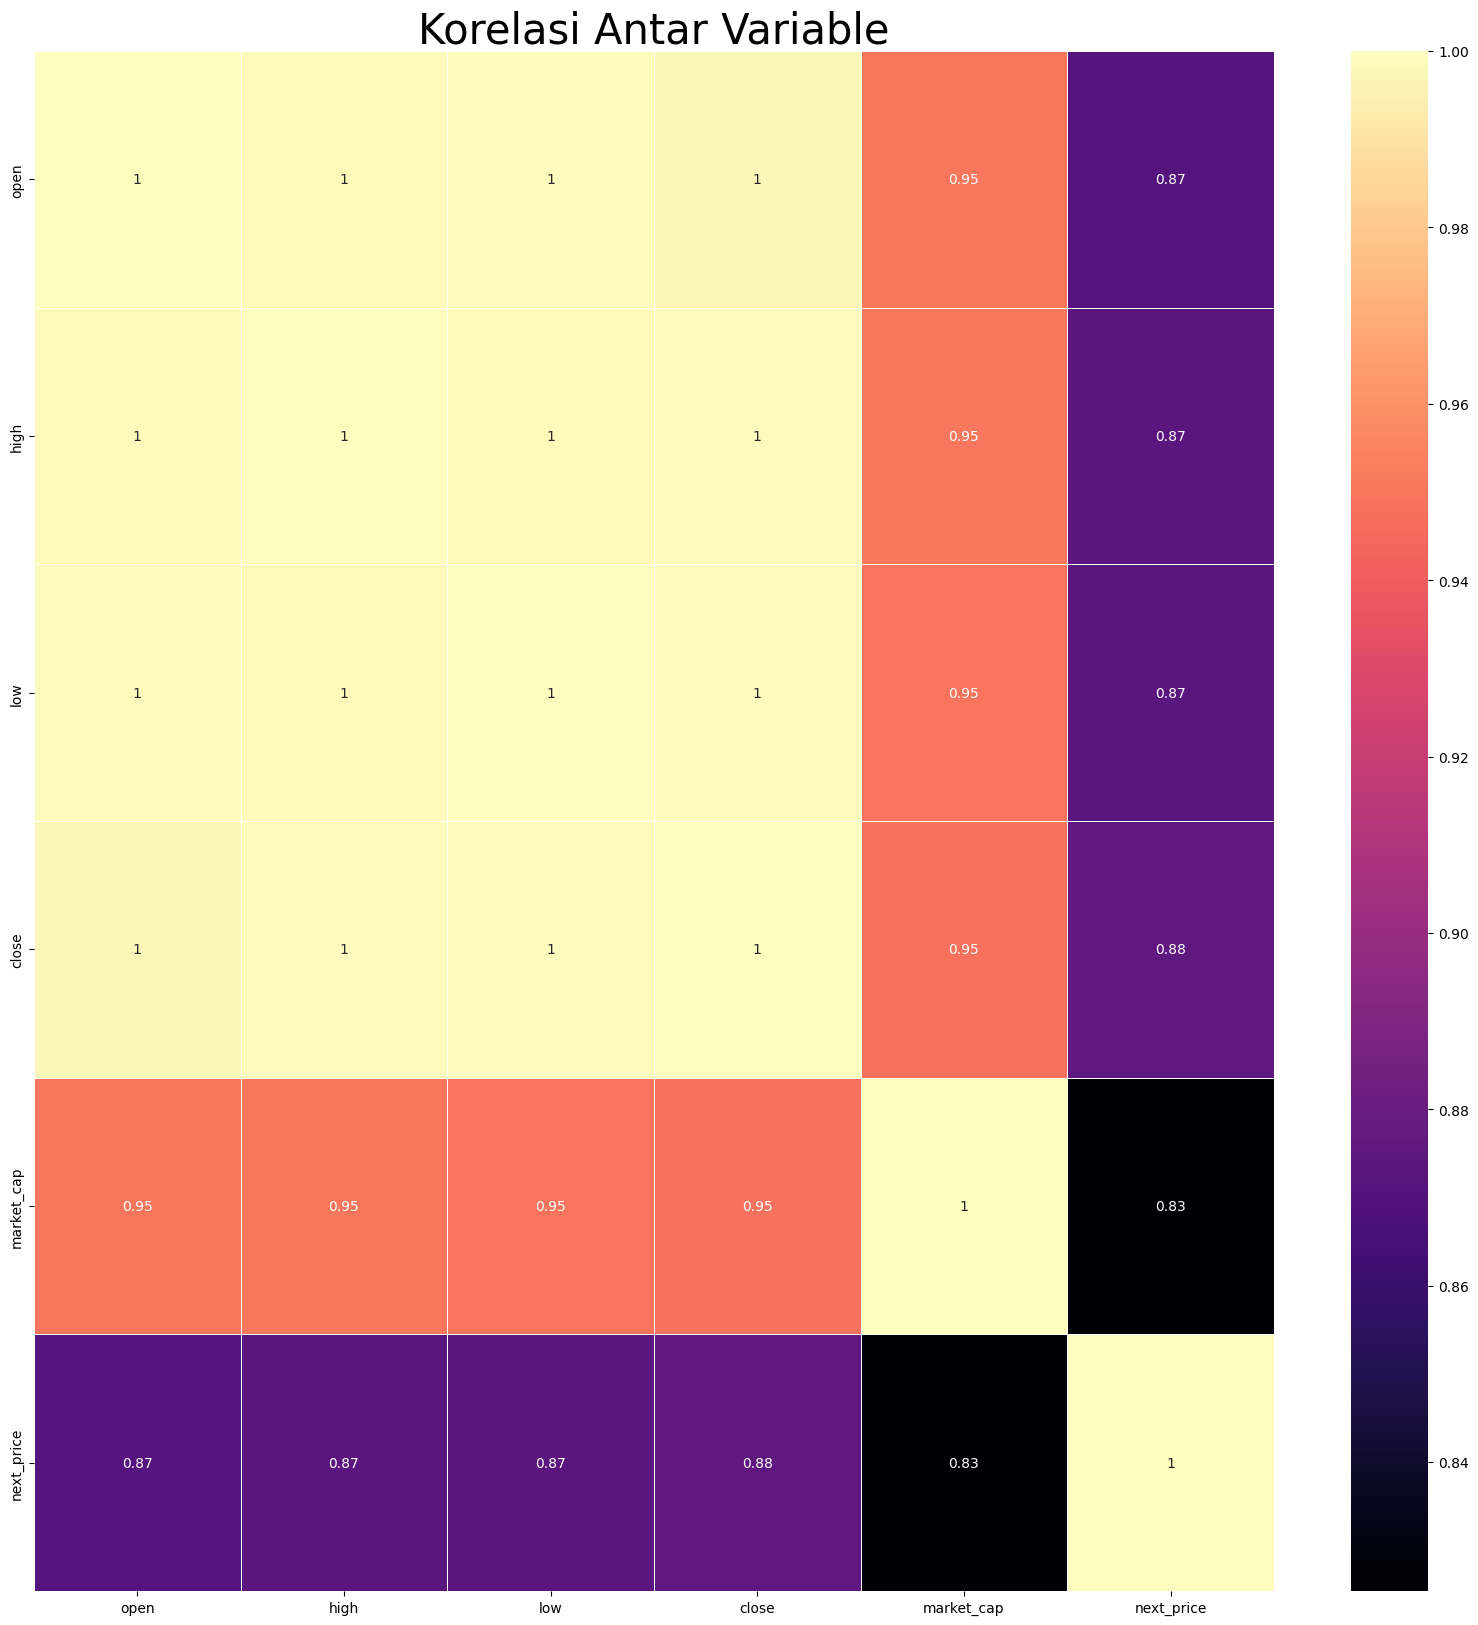

In [ ]:
# melihat korelasi antar variable untuk mencari feature yang penting
plt.figure(figsize=(20,20))
cor = btcdata.corr()
sns.heatmap(cor,annot=True, linewidth=.5, cmap="magma")
plt.title('Korelasi Antar Variable', fontsize = 30)
plt.show()

#LSTM

In [ ]:
btcdata

,open,high,low,close,market_cap,next_price
time,,,,,,
2025-08-31 18:04:00+00:00,109009.70,109009.78,108963.19,108964.00,2.169975e+12,109125.27
2025-08-31 18:04:01+00:00,109009.70,109009.78,108963.19,108964.00,2.169975e+12,109125.27
2025-08-31 18:04:02+00:00,109009.70,109009.78,108963.19,108964.00,2.169975e+12,109125.27
2025-08-31 18:04:03+00:00,109009.70,109009.78,108963.19,108964.00,2.169975e+12,109125.27
2025-08-31 18:04:04+00:00,109009.70,109009.78,108963.19,108964.00,2.169975e+12,109125.27
...,...,...,...,...,...,...
2025-09-02 02:53:56+00:00,109823.39,109835.85,109810.95,109810.95,2.185830e+12,110304.58
2025-09-02 02:53:57+00:00,109823.39,109835.85,109810.95,109810.95,2.185830e+12,110304.58
2025-09-02 02:53:58+00:00,109823.39,109835.85,109810.95,109810.95,2.185830e+12,110304.58


In [ ]:
# ============================================
# 🔧 Training Script untuk Prediksi Harga Bitcoin
# ============================================

import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ------------------ Custom Scaler ------------------
class TimeSeriesScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = RobustScaler()

    def fit(self, X, y=None):
        n_samples, n_timesteps, n_features = X.shape
        X_reshaped = X.reshape(-1, n_features)
        self.scaler.fit(X_reshaped)
        return self

    def transform(self, X):
        n_samples, n_timesteps, n_features = X.shape
        X_reshaped = X.reshape(-1, n_features)
        X_scaled = self.scaler.transform(X_reshaped)
        return X_scaled.reshape(n_samples, n_timesteps, n_features)

# ------------------ Sequence Builder ------------------
def create_padded_sequences(X, y, max_len=48):
    Xs, ys = [], []
    for i in range(len(X)):
        seq_x = X[max(0, i - max_len + 1):i + 1]
        pad_len = max_len - len(seq_x)
        if pad_len > 0:
            pad_array = np.zeros((pad_len, X.shape[1]))
            seq_x = np.vstack([pad_array, seq_x])
        Xs.append(seq_x)
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# ------------------ Build LSTM Model ------------------
def build_lstm_model(input_shape, units=64, dropout_rate=0.2, lr=0.001):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=input_shape))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

# ------------------ Load Data ------------------
# Pastikan btcdata sudah tersedia sebagai DataFrame
# dengan kolom 'next_price' sebagai target
features = btcdata.drop(columns=['next_price'])
target = btcdata['next_price']

MAX_SEQ_LEN = 48
X_seq, y_seq = create_padded_sequences(features.values, target.values, max_len=MAX_SEQ_LEN)

# ------------------ Train-Test Split ------------------
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.25, shuffle=False
)

# ------------------ Pipeline untuk Preprocessing ------------------
scaler = TimeSeriesScaler()
pipeline = Pipeline([("scaler", scaler)])

# Fit pipeline dan transform data
X_train_scaled = pipeline.fit_transform(X_train_seq)
X_test_scaled = pipeline.transform(X_test_seq)

# ------------------ Train Model ------------------
model = build_lstm_model(input_shape=(MAX_SEQ_LEN, X_train_scaled.shape[2]),
                         units=64, dropout_rate=0.2, lr=0.001)

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.fit(X_train_scaled, y_train_seq,
          validation_data=(X_test_scaled, y_test_seq),
          epochs=30, batch_size=32, callbacks=[early_stop], verbose=1)

# ------------------ Save Model & Pipeline ------------------
model.save("lstm_model.keras", include_optimizer=False)

with open("scaler_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

best_params = {
    'units': 64,
    'dropout_rate': 0.2,
    'lr': 0.001,
    'epochs': 30,
    'batch_size': 32
}
with open("lstm_best_params.pkl", "wb") as f:
    pickle.dump(best_params, f)

print("✅ Model, pipeline, dan parameter berhasil disimpan.")

Epoch 1/30
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 202s 70ms/step - loss: 11798446080.0000 - val_loss: 11829799936.0000
Epoch 2/30
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 190s 69ms/step - loss: 11759000576.0000 - val_loss: 11792003072.0000
Epoch 3/30
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 199s 72ms/step - loss: 11721660416.0000 - val_loss: 11754216448.0000
Epoch 4/30
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 196s 70ms/step - loss: 11683371008.0000 - val_loss: 11715116032.0000
Epoch 5/30
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 201s 70ms/step - loss: 11644139520.0000 - val_loss: 11676293120.0000
Epoch 6/30
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 207s 71ms/step - loss: 11606821888.0000 - val_loss: 11637569536.0000
Epoch 7/30
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 197s 70ms/step - loss: 11567639552.0000 - val_loss: 11598908416.0000
Epoch 8/30
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 194s 70ms/step - loss: 11528236032.0000 - val_loss: 11560321024.0000
Epoch 9/30
2771/2771 ━━━━━━━━━━━━━━━━━━━━ 205s 71ms/step - loss: 11490196480.0000 - val_loss: 11521799168.0000
E

In [ ]:
files.download('lstm_model.keras')
files.download('scaler_pipeline.pkl')
files.download('lstm_best_params.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>